In [52]:
# load packages
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Project Overview

* This project analyzes nearly a decade of New York Times Hardcover Fiction bestseller data. After merging and cleaning all scraped SQL tables, this first notebook focuses on exploratory data analysis (EDA). 

* The goal is to grasp trends in author and book dominance, publisher market share, and seasonal patterns. Put together, I hope to give insight into a central question: $\textbf{What can aspiring novelists learn from the patterns of the NYT bestseller market?}$

# Load Data

In [53]:
# load tables from database
conn = sqlite3.connect("../../db/nyt_books.db")
books = pd.read_sql("SELECT * FROM books", conn)
appearances = pd.read_sql("SELECT * FROM appearances", conn)

conn.close()

books.head(), appearances.head()

(          isbn13 isbn10                   title  \
 0  9780385548984   None               THE WIDOW   
 1  9780385546898   None   THE SECRET OF SECRETS   
 2  9780593972700   None              ALCHEMISED   
 3  9781538774700   None     GONE BEFORE GOODBYE   
 4  9781668014905   None  THE CHRISTMAS STRANGER   
 
                                author      publisher  \
 0                        John Grisham      Doubleday   
 1                           Dan Brown      Doubleday   
 2                            SenLinYu        Del Rey   
 3  Reese Witherspoon and Harlan Coben  Grand Central   
 4                  Richard Paul Evans        Gallery   
 
                                          description  
 0  When Simon Latch, a lawyer in rural Virginia, ...  
 1  As he searches for the missing noetic scientis...  
 2  After the war, an imprisoned alchemist is sent...  
 3  When a mysterious man disappears, the former c...  
 4  Three years after a tragedy, a computer repair...  ,
     

In [54]:
# merge tables
df = appearances.merge(books, on="isbn13", how="left")
df["list_date"] = pd.to_datetime(df["list_date"])
df = df.sort_values(["list_date", "rank"]).reset_index(drop=True)
# drop isbn10
df = df.drop(columns=["isbn10"])

df.head()

,list_date,isbn13,rank,weeks_on_list,title,author,publisher,description
0,2018-07-15,9780316412698,1,4,THE PRESIDENT IS MISSING,James Patterson and Bill Clinton,"Little, Brown and Knopf",President Jonathan Duncan takes on adversaries...
1,2018-07-15,9780399178924,2,1,ALL WE EVER WANTED,Emily Giffin,Ballantine,A scandal sends members of two Nashville famil...
2,2018-07-15,9781501180989,3,6,THE OUTSIDER,Stephen King,Scribner,A detective investigates a seemingly wholesome...
3,2018-07-15,9780316375269,4,2,THE PERFECT COUPLE,Elin Hilderbrand,"Little, Brown",A body is found in Nantucket Harbor hours befo...
4,2018-07-15,9781250161598,5,5,SHELTER IN PLACE,Nora Roberts,St. Martin's,Survivors of a mass shooting outside a mall in...


# Data Checks

* After loading and merging the SQL tables into a dataset, I will conduct quality checks.

In [55]:
# missing values
df.isnull().mean().sort_values(ascending=False)

list_date        0.0
isbn13           0.0
rank             0.0
weeks_on_list    0.0
title            0.0
author           0.0
publisher        0.0
description      0.0
dtype: float64

* The merged dataset contains no missing values, indicating a clean scraping process.

In [56]:
# data characteristics
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5775 entries, 0 to 5774
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   list_date      5775 non-null   datetime64[ns]
 1   isbn13         5775 non-null   int64         
 2   rank           5775 non-null   int64         
 3   weeks_on_list  5775 non-null   int64         
 4   title          5775 non-null   object        
 5   author         5775 non-null   object        
 6   publisher      5775 non-null   object        
 7   description    5775 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 361.1+ KB


In [57]:
# range of time
df["list_date"].min(), df["list_date"].max()

(Timestamp('2018-07-15 00:00:00'), Timestamp('2025-11-23 00:00:00'))

* The data spans all books from 2018-07-15 to the current day, which is enough to identify long-term patterns in the publishing industry.

In [58]:
# unique counts
unique_books = df["isbn13"].nunique()
unique_authors = df["author"].nunique()
unique_publishers = df["publisher"].nunique()

print(f"Unique books: {unique_books}")
print(f"Unique authors: {unique_authors}")
print(f"Unique publishers: {unique_publishers}")

Unique books: 1366
Unique authors: 612
Unique publishers: 120


* Notice that there are more than double the number of unique books (1366) than unique authors. (612), potentially indicating that recurring authors have a large share of the list. 

* Additionally, considering that there are 5775 book entries but only 1366 unique books, we will look into the lifespan of books on the bestselling list.

* These observations raise questions such as: To what extent do certain authors dominate the industry? Which books have a higher life span and why?

# EDA and Visualizations

## Question: How many weeks do most bestselling books stay on the list?

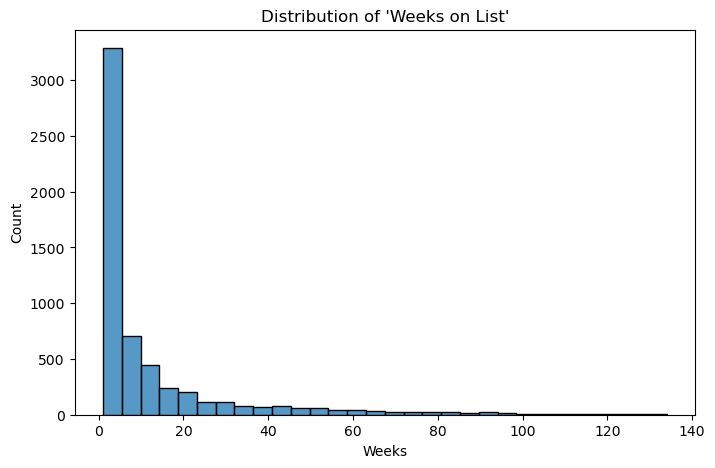

<Figure size 640x480 with 0 Axes>

In [80]:
# 'weeks on list' histogram
plt.figure(figsize=(8,5))
sns.histplot(df["weeks_on_list"], bins=30)
plt.title("Distribution of 'Weeks on List'")
plt.xlabel("Weeks")
plt.ylabel("Count")
plt.show()
plt.savefig("../images/weeks_on_list_distribution.png")

In [60]:
# distribution of weeks_on_list
df["weeks_on_list"].describe()

count    5775.000000
mean       12.373680
std        19.622836
min         1.000000
25%         2.000000
50%         4.000000
75%        13.000000
max       134.000000
Name: weeks_on_list, dtype: float64

In [61]:
# mode
mode_weeks = df["weeks_on_list"].mode()[0]
print(f"Mode of 'weeks_on_list': {mode_weeks} week")

Mode of 'weeks_on_list': 1 week


* The distribution of 'weeks on list' is heavily right skewed, with the median lifespan being only 4 weeks. 

* Most books stay on the list for only 1 week, suggesting difficulty in gaining traction.

* A small number of books remain for many months or longer, which is a pattern consistent with the “winner-take-most” sales environment.

## 2. What are the top books? (metric: weeks on list)

In [62]:
# top 15 books by number of weeks on list
top_books = (
    df.groupby(["isbn13", "title", "author"])["list_date"]
      .count()
      .sort_values(ascending=False)
      .head(15)
)

top_books

isbn13         title                                 author            
9780735219090  WHERE THE CRAWDADS SING               Delia Owens           134
9780525559474  THE MIDNIGHT LIBRARY                  Matt Haig             106
9780385547345  LESSONS IN CHEMISTRY                  Bonnie Garmus          99
9781649374042  FOURTH WING                           Rebecca Yarros         93
9781649374172  IRON FLAME                            Rebecca Yarros         79
9780063251922  DEMON COPPERHEAD                      Barbara Kingsolver     70
9781250178633  THE WOMEN                             Kristin Hannah         66
9781501171345  THE LAST THING HE TOLD ME             Laura Dave             65
9780063204157  REMARKABLY BRIGHT CREATURES           Shelby Van Pelt        64
9781250301697  THE SILENT PATIENT                    Alex Michaelides       56
9780385550369  JAMES                                 Percival Everett       52
9780593321201  TOMORROW, AND TOMORROW, AND TOMORROW  Gabrie

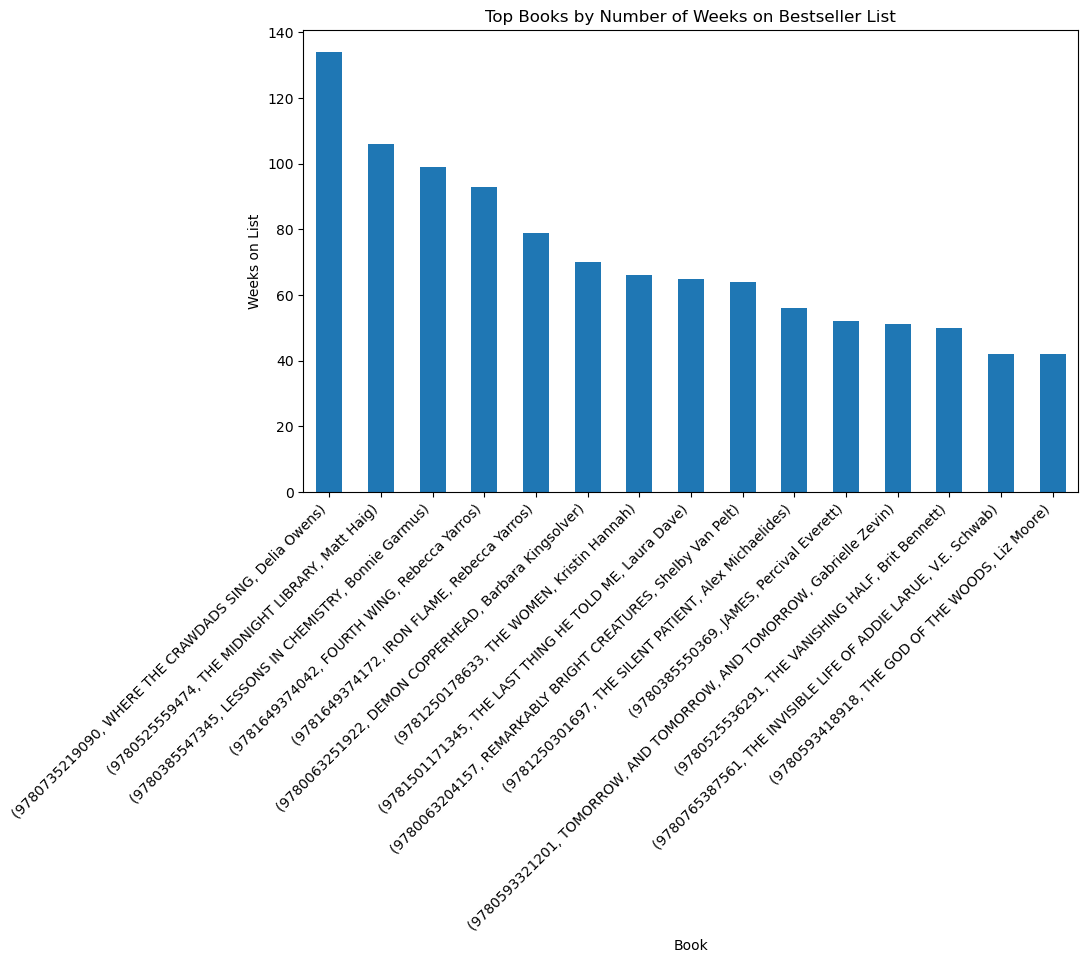

<Figure size 640x480 with 0 Axes>

In [81]:
# visualization
plt.figure(figsize=(10,6))
top_books.plot(kind="bar")
plt.title("Top Books by Number of Weeks on Bestseller List")
plt.ylabel("Weeks on List")
plt.xlabel("Book")
plt.xticks(rotation=45, ha="right")
plt.show()
plt.savefig("../images/top_books_weeks_on_list.png")

* A pattern among books with highest lifespans (i.e. top 3) is that most can be categorized as upmarket or literary fiction. The 6th highest book is even a Pulitzer Prize winner, indicating that critical acclaim and merit can extend visibility.

* A smaller but non-negligible portion of top hits can be categorized as commercial fiction, such as The Empyrean series (Fourth Wing, Iron Flame) and The Last Thing He Told Me. It seems that genre hits can achieve comparable longevity through strong reader demand and publisher support.

## 3. Who are the top authors? (metric: weeks on list)

In [64]:
# top 15 authors by number of weeks on list
top_authors = (
    df.groupby("author")["list_date"]
      .count()
      .sort_values(ascending=False)
      .head(15)
)

top_authors

author
Rebecca Yarros        219
John Grisham          172
Stephen King          163
Delia Owens           134
David Baldacci        134
Danielle Steel        126
Matt Haig             111
Kristin Hannah        102
Bonnie Garmus          99
Nicholas Sparks        89
Elin Hilderbrand       80
Barbara Kingsolver     76
Alex Michaelides       69
Laura Dave             67
Shelby Van Pelt        64
Name: list_date, dtype: int64

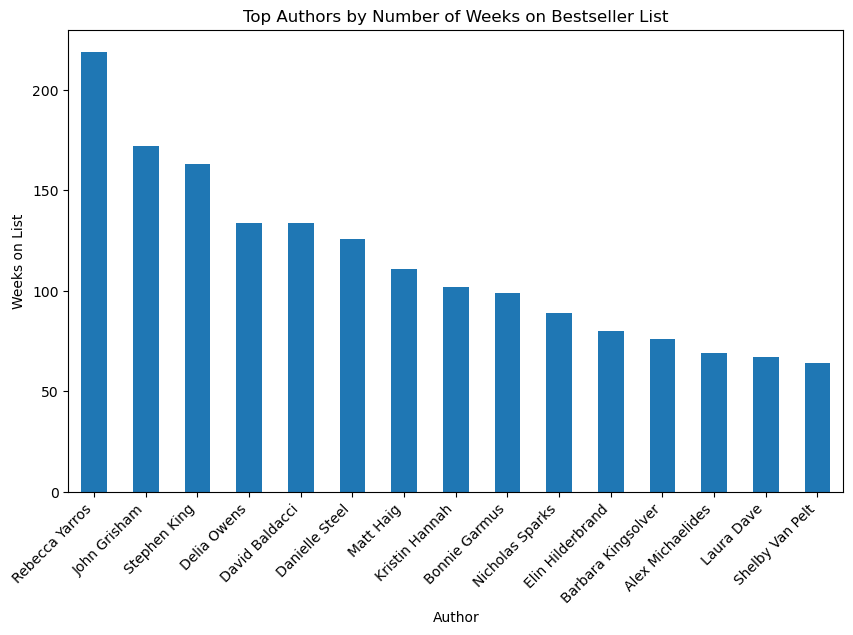

<Figure size 640x480 with 0 Axes>

In [82]:
# visualization
plt.figure(figsize=(10,6))
top_authors.plot(kind="bar")
plt.title("Top Authors by Number of Weeks on Bestseller List")
plt.ylabel("Weeks on List")
plt.xlabel("Author")
plt.xticks(rotation=45, ha="right")
plt.show()
plt.savefig("../images/top_authors_weeks_on_list.png")

* We saw in the "Data Check" section that there are far fewer unique authors than unique books, implying that many authors publish multiple bestsellers.

* From a glance, top authors in this list such as Rebecca Yarros, John Grisham, and Stephen King (top 3) are known to be established, recurring authors with strong publisher backing.

* Additionally, most higher ranking authors in this list can informally be categorized as "commercial" fiction - writing for broad entertainment in comparison to upmarket or literary fiction.

* This observation is in interesting contrast to the top books list, which had a higher proportion of upmarket and literary fiction. Could it be that top authors sustain bestseller presence through consistent output, rather than aiming to publish top hits?

## 4. What are the top publishers? (metric: number of appearances)

In [66]:
# top publishers by number of appearances
publisher_counts = (
    df.groupby("publisher")["isbn13"]
      .count()
      .sort_values(ascending=False)
      .head(15)
)

publisher_counts

publisher
Little, Brown    483
Doubleday        384
Putnam           357
Grand Central    305
St. Martin's     264
Ballantine       261
Harper           254
Viking           250
Red Tower        246
Scribner         222
Atria            201
Delacorte        199
Riverhead        195
Knopf            174
Morrow           166
Name: isbn13, dtype: int64

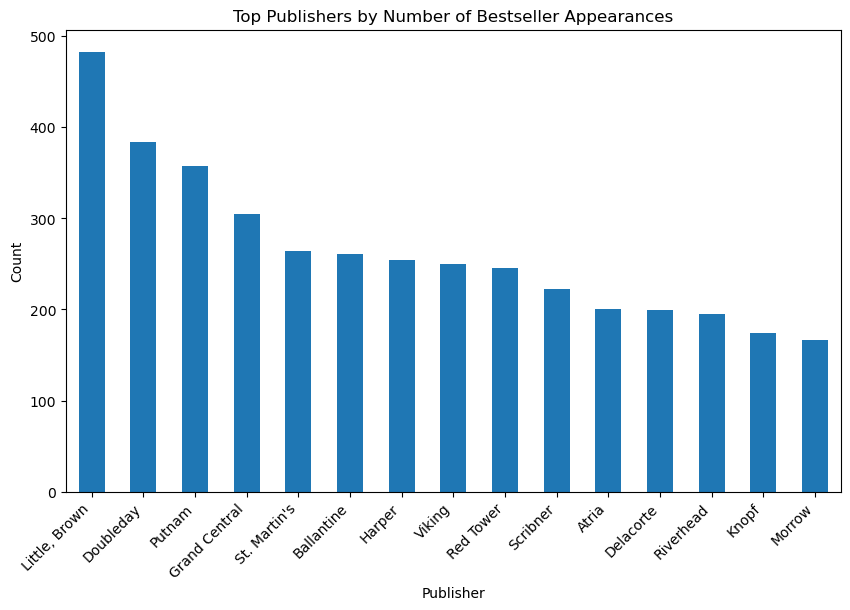

<Figure size 640x480 with 0 Axes>

In [83]:
# visualization
plt.figure(figsize=(10,6))
publisher_counts.plot(kind="bar")
plt.title("Top Publishers by Number of Bestseller Appearances")
plt.ylabel("Count")
plt.xlabel("Publisher")
plt.xticks(rotation=45, ha="right")
plt.show()
plt.savefig("../images/top_publishers_weeks_on_list.png")

* For this analysis, I wanted to see if any publisher had a dominance over the industry. The top ranking publisher, Little, Brown (division of the Hachette Book Group), is attributed to almost 100 more weeks on the bestselling list than the second ranking publisher, Doubleday. 

* This difference is most likely explained by authors who publish bestsellers with higher lifespan on the list, rather than publishing a higher volume of bestselling books. Let us confirm this by switching to "unique books" as a metric, rather than count.

In [68]:
publisher_unique_books = (
    df.groupby("publisher")["isbn13"]
      .nunique()
      .reset_index(name="unique_books")
      .sort_values("unique_books", ascending=False)
      .head(15)
      .set_index("publisher")
)

publisher_unique_books

,unique_books
publisher,
"Little, Brown",95
Putnam,90
St. Martin's,69
Grand Central,66
Delacorte,62
Morrow,61
Atria,53
Knopf,53
Ballantine,53


<Figure size 1000x600 with 0 Axes>

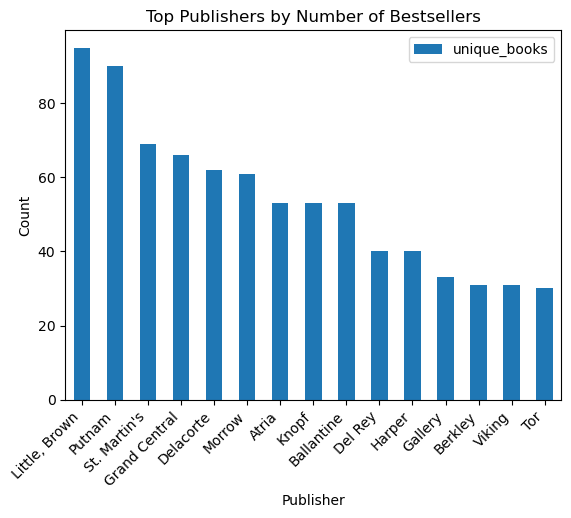

<Figure size 640x480 with 0 Axes>

In [84]:
# visualization
plt.figure(figsize=(10,6))
publisher_unique_books.plot(kind="bar")
plt.title("Top Publishers by Number of Bestsellers")
plt.ylabel("Count")
plt.xlabel("Publisher")
plt.xticks(rotation=45, ha="right")
plt.show()
plt.savefig("../images/top_publishers_unique_books.png")

* Now, we see that Little, Brown and Putnam are attributed to around 20 more bestsellers than the next top publisher. Proportionally, this is still a respectable lead.

* We can surmise that publisher strength manifests both as producing consistent bestselling authors, and also sustaining long-running titles. For a new author, signing with a top-tier publisher may significantly increase the chance of breaking onto and staying on the list.

## 5. Which month sees the most bestselling books emerge?

In [70]:
# seasonal trends
df["month"] = df["list_date"].dt.month

unique_by_month = (
    df[["isbn13", "month"]]
    .drop_duplicates()
    .groupby("month")
    .count()
    .rename(columns={"isbn13": "unique_books"})
)

unique_by_month


,unique_books
month,
1,171
2,164
3,202
4,185
5,199
6,200
7,193
8,204
9,244


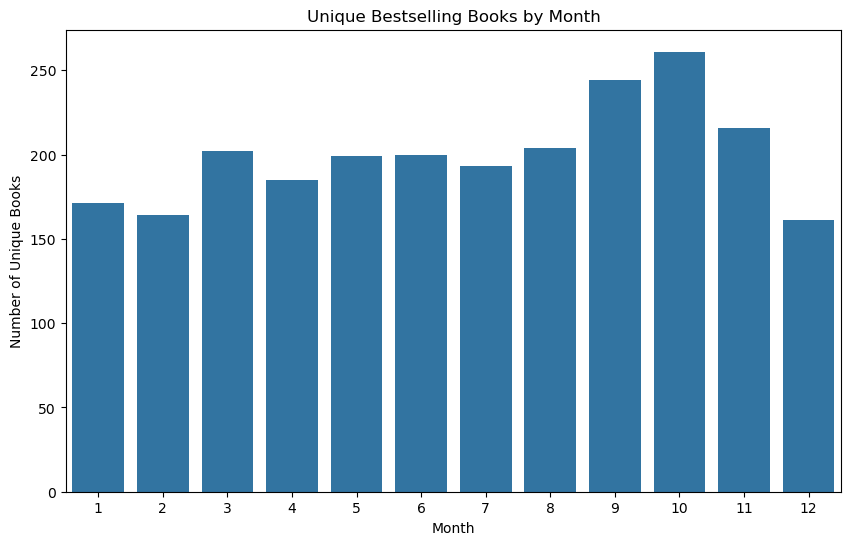

<Figure size 640x480 with 0 Axes>

In [85]:
# visualization
plt.figure(figsize=(10,6))
sns.barplot(x=unique_by_month.index, y=unique_by_month["unique_books"])
plt.title("Unique Bestselling Books by Month")
plt.xlabel("Month")
plt.ylabel("Number of Unique Books")
plt.show()
plt.savefig("../images/top_books_weeks_on_list.png")

* A seasonal trend analysis indicates that most bestsellers break in during the months of September and October. This makes sense, as that is typically in time for the holidays. 

* However, for an aspiring writer, this could indicate a more competitive release window during Q4. A spring or summer release may offer less crowded competition, depending on genre.

# Summary: What can an aspiring novelist learn from NYT bestseller trends?

1. The bestseller market is extremely top-heavy. Most books last only a week on the list; a small minority dominate for months.

2. Author reputation is an important factor. A handful of recurring, commercially established authors account for a large share of placements. Building a brand over time is impactful for making it onto the list.

3. Publisher strength influences outcomes. Big houses like Little, Brown produce high longevity books and the largest number of unique bestsellers.

4. Books can perform well even without being commercial. Several high-lifespan titles are literary or award-winning, indicating that book quality and acclaim can counterbalance market dominance by commercial authors.

5. Fall is the peak release and competition season. Most new bestsellers break onto the list in September and October. Aspiring writers should understand both the advantages and challenges of launching in Q4.

In [73]:
# save data
os.makedirs("../../data/analysis", exist_ok=True)
df.to_csv("../../data/analysis/bestsellers_analysis_ready.csv", index=False)

df.head()

,list_date,isbn13,rank,weeks_on_list,title,author,publisher,description,month
0,2018-07-15,9780316412698,1,4,THE PRESIDENT IS MISSING,James Patterson and Bill Clinton,"Little, Brown and Knopf",President Jonathan Duncan takes on adversaries...,7
1,2018-07-15,9780399178924,2,1,ALL WE EVER WANTED,Emily Giffin,Ballantine,A scandal sends members of two Nashville famil...,7
2,2018-07-15,9781501180989,3,6,THE OUTSIDER,Stephen King,Scribner,A detective investigates a seemingly wholesome...,7
3,2018-07-15,9780316375269,4,2,THE PERFECT COUPLE,Elin Hilderbrand,"Little, Brown",A body is found in Nantucket Harbor hours befo...,7
4,2018-07-15,9781250161598,5,5,SHELTER IN PLACE,Nora Roberts,St. Martin's,Survivors of a mass shooting outside a mall in...,7
